# CT-1 Training Notebook

## 1. Introduction

## 2. Training Data Pre-processing

In [7]:
# Create image dataset from data directory
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import numpy as np

# Define parameters for dataloader
batch_size = len(os.listdir('data/canetoad')) # length of dataset
img_height = 256
img_width = 256
data_dir = 'data'

In [8]:
# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 10 files belonging to 1 classes.
Using 8 files for training.


In [9]:
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 10 files belonging to 1 classes.
Using 2 files for validation.


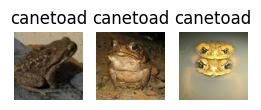

In [10]:
# Plot the first 3 images in training set

import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(3,1))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

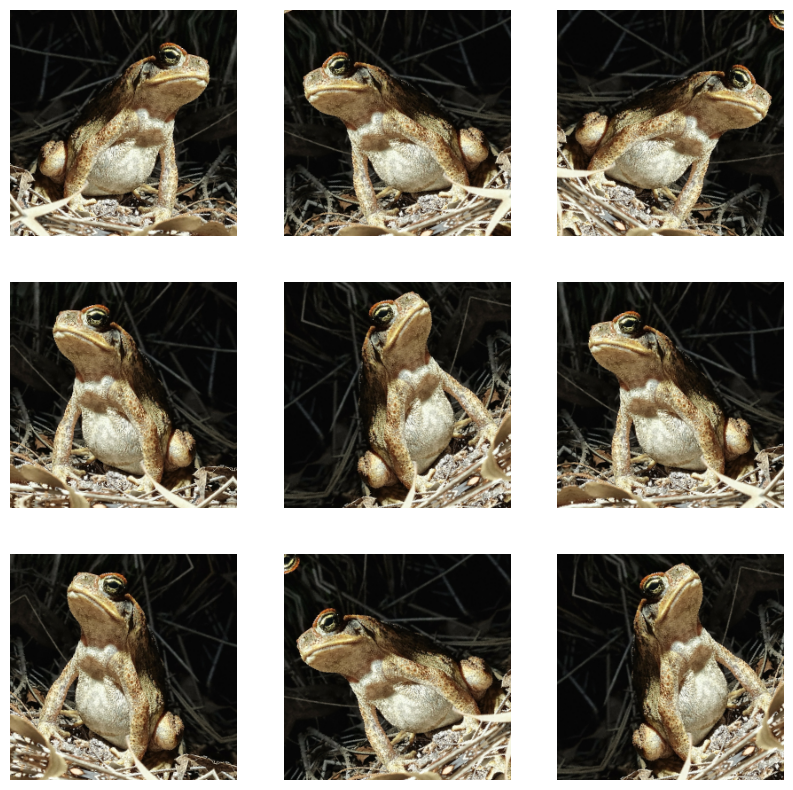

In [11]:
# Apply data augmentation to training dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"), # Randomly flip images horizontally
  tf.keras.layers.RandomRotation(0.1) # Randomly rotate images by 10%
])

# Visualize data augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 3. Model Training

In [6]:
# Create base model using Xception
base_model = tf.keras.applications.Xception(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=(img_height, img_width, 3),
  include_top=False)  # Do not include the ImageNet classifier at the top.

In [7]:
# Print out base model architecture
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 127, 127,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 127, 127,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 125, 125,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 125, 125,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 125, 125,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 125, 125,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 125, 125,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 125, 125,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 125, 125,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 125, 125,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 63, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 63, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 63, 63,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [8]:
# Peek at example batch of images
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 8, 8, 2048)


In [9]:
# Freeze the convolutional base
base_model.trainable = False

In [10]:
# Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 2048)


In [11]:
# Add prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 1)


In [12]:
# Build model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
# Peek at model architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
# Compile and train top layer of model

base_learning_rate = 0.001 # Adjust if necessary
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
initial_epochs = 10 # Adjust if necessary

model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3750 - loss: 5.1212 - val_accuracy: 0.5000 - val_loss: 3.8099
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - accuracy: 0.7500 - loss: 3.7179 - val_accuracy: 0.5000 - val_loss: 1.1650
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step - accuracy: 0.6250 - loss: 3.4955 - val_accuracy: 1.0000 - val_loss: 0.0220
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - accuracy: 0.8750 - loss: 0.2817 - val_accuracy: 1.0000 - val_loss: 2.3487e-04
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - accuracy: 0.8750 - loss: 3.8642 - val_accuracy: 1.0000 - val_loss: 2.3232e-06
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step - accuracy: 0.8750 - loss: 0.5643 - val_accuracy: 1.0000 - val_loss: 3.6563e-08
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step - accuracy: 1.0000 - loss: 0.1423 - val_accuracy: 1.0000 - val_loss: 9.0396e-10
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step - accuracy: 0.8750 - loss: 0.1248 - val_accuracy: 1.0000 - val_los

In [15]:
# Evaluate model
model.evaluate(val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 1.0000 - loss: 1.1212e-13


[1.1211542219786985e-13, 1.0]

In [16]:
# Save model
model.save('ct-1.keras')

## References and resources
* https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
* https://mobidev.biz/blog/few-shot-learning-explained-examples-applications-research
* https://keras.io/guides/transfer_learning/
* https://www.tensorflow.org/tutorials/load_data/images
* https://www.tensorflow.org/tutorials/images/transfer_learning